In [4]:
from analyze_partition_agg import *
from analyze_synthgraph import *

### Results Per-Fraud Detector Subsample-and-Aggregate

In [2]:
res_bias = analyze_pda_validation_results_oneshot(stat='aucs', eps=1000., n_noise_draws=50)

In [3]:
# fixing sub_rate, increasing k increases the bias
stats = [c for c in res_bias.columns if 'bias' in c]
df = res_bias.melt(id_vars=['dataset', 'sub_rate', 'k', 'method', 'eps'], value_vars=stats, var_name='algo', value_name='bias')
df['algo'] = ['_'.join(a.split('_')[1:]) for a in df['algo']]
df = df[~df.algo.isin(['agg1', 'agg2', 'agg_max', 'random'])]
df['algo'] = df['algo'].map(ALGORITHM_NAMES)
df.head()

,dataset,sub_rate,k,method,eps,algo,bias
0,amazon_sbm,0.05,20,laplace,1000.0,Clustering Coeff,-0.419004
1,amazon_sbm,0.05,50,laplace,1000.0,Clustering Coeff,-0.423021
2,amazon_sbm,0.05,100,laplace,1000.0,Clustering Coeff,-0.423360
3,amazon_sbm,0.05,200,laplace,1000.0,Clustering Coeff,-0.423421
4,amazon_sbm,0.10,10,laplace,1000.0,Clustering Coeff,-0.403500


In [4]:
def plot_bias_vs_param(plot, datasets, fixed_param_name, fixed_param_value):
    plot = df[(df[fixed_param_name] == fixed_param_value) & (df['dataset'].isin(datasets))].copy()
    plot['abs_bias'] = plot['bias'].abs()

    if fixed_param_name == 'k':
        x_label = 'Fraud Subsample Rate'
        param_name = 'sub_rate'
    if fixed_param_name == 'sub_rate':
        x_label = 'Number of Partitions'
        param_name = 'k'

    markers = ['o', 's', 'v', 'D', '<', 'd', '>']

    g = sns.relplot(data=plot, x=param_name, y='bias', col='dataset', kind='line', col_order=datasets,
                    hue='algo', style='algo', markers=markers, dashes=False, lw=3, markersize=8)

    # add horizontal line at 0 to each subplot  
    for ax in g.axes.flat:
        ax.axhline(0, ls='--', color='black')

    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16)
        
    g.set_ylabels('Bias of AUC Score', fontsize=16)
    g.set_xlabels(x_label, fontsize=16)

    # increase fontsize of x and y tick labels
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=14)

    # move legend outside plot to the botom and split into two rows
    g.figure.legend(title='Fraud Detector', ncols=3, bbox_to_anchor=(0.5, -0.25), loc='lower center', fontsize=12, title_fontsize=14)
    g._legend.set_visible(False)

    plt.tight_layout()
    save_path=f"results/figures/bias_vs_{param_name}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)
    plt.show()


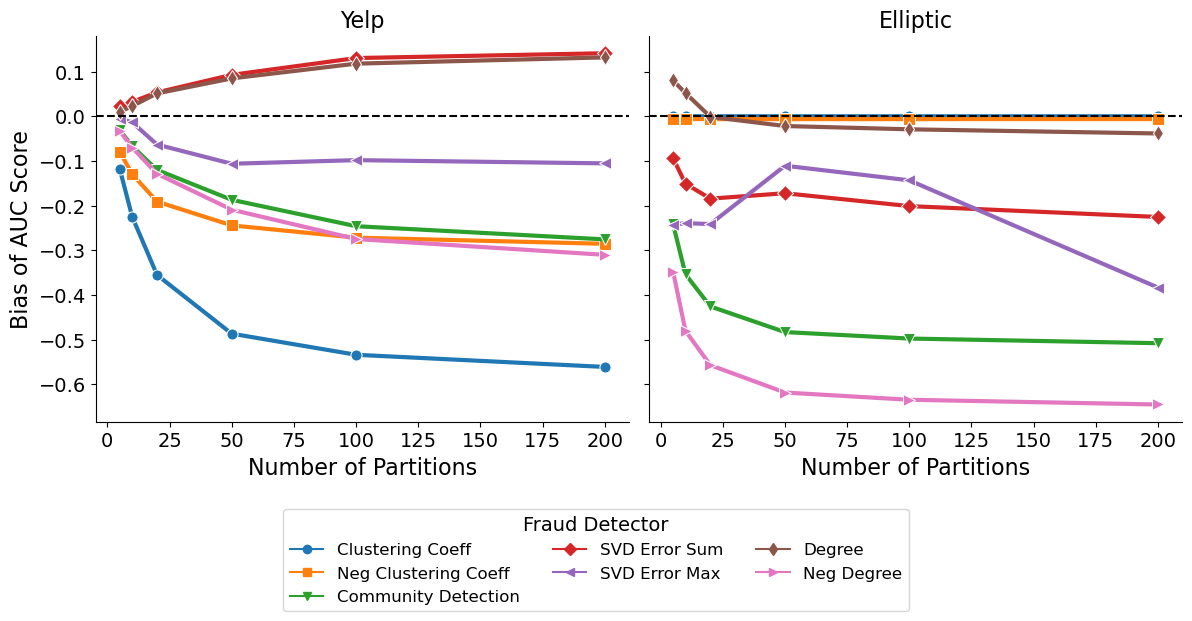

In [5]:
SUB_RATE = 0.25
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

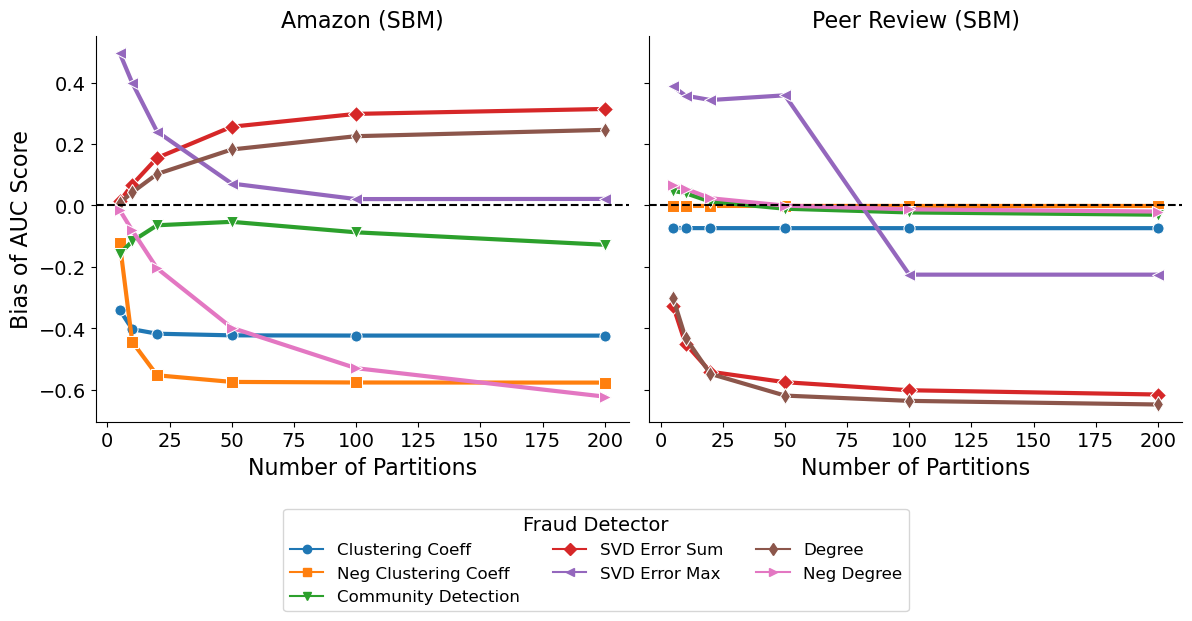

In [6]:
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'sub_rate', SUB_RATE)

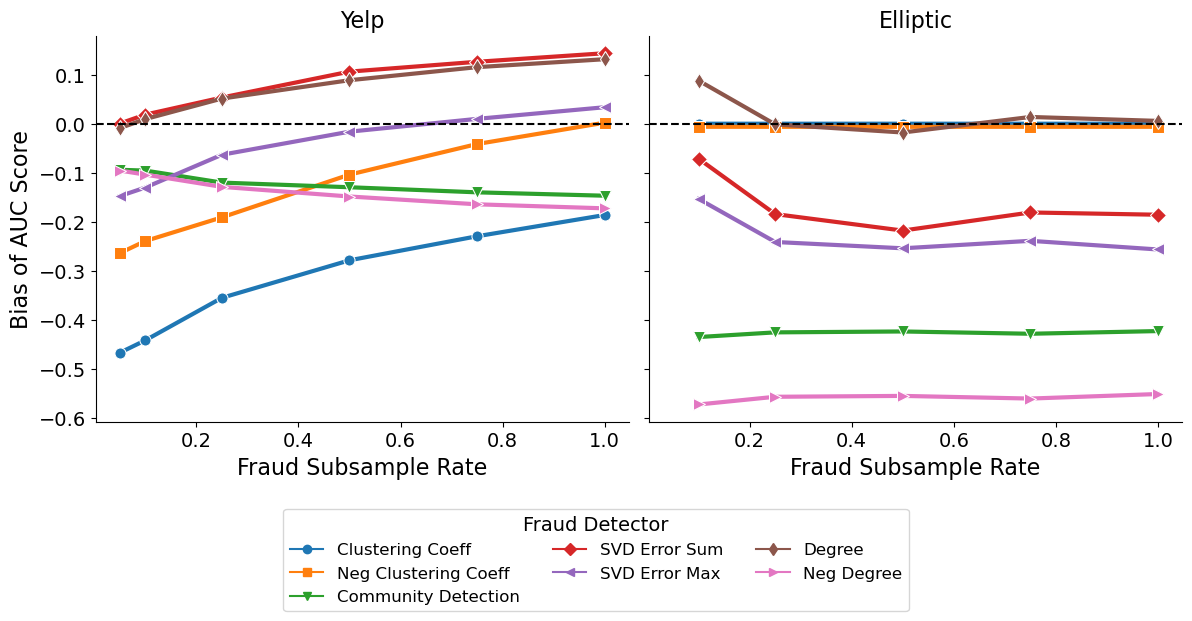

In [7]:
K = 20
DATASETS = ['yelp', 'elliptic']
plot_bias_vs_param(df, DATASETS, 'k', K)

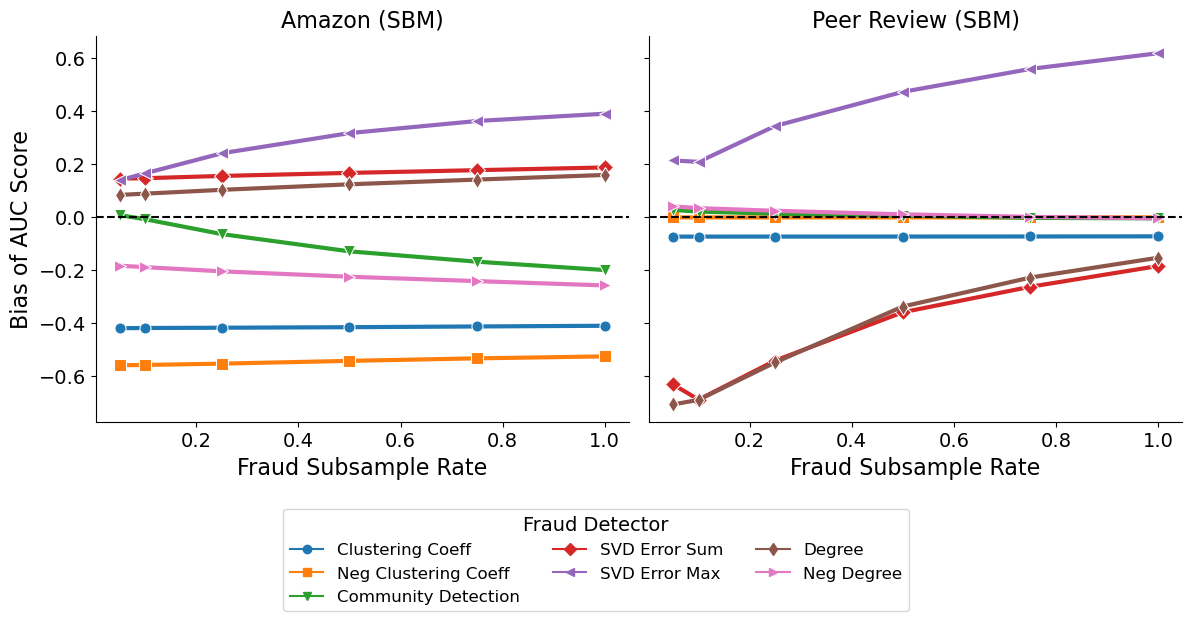

In [8]:
K = 20
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_bias_vs_param(df, DATASETS, 'k', K)

## Results for Leaderboard Subsample-and-Aggregate 

In [13]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [10]:
random_baselines = get_leaderboard_baselines(split='val')

=== Kendall Tau Baseline for Validation Sets ===
Test vs. Val yelp: 0.0033
Random: 5.2016
Test vs. Val elliptic: 0.021
Random: 5.9705
Test vs. Val amazon_sbm: 0.5359
Random: 8.1351
Test vs. Val peer_review_sbm: 1.1187
Random: 8.6117


In [275]:
def add_hatches(g, n_bars=2):
    # hatches for each bar
    hatches = ['//', '..', 'xx', '++', 'oo', 'O', '||', '\\\\', '|||', '---', '///', '+++']
    hatches = hatches[:n_bars]

    # iterate through each subplot / Facet
    for ax in g.axes.flat:
        # select the correct patches
        patches = [patch for patch in ax.patches]

        # the number of patches should be evenly divisible by the number of hatches
        h = [[hatch]*(len(patches) // n_bars) for hatch in hatches]
        h = [item for sublist in h for item in sublist]
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor('none')

    return hatches


def plot_k_vs_kendalltau(df, sub_rate, datasets, eps, random_baselines):
    df = df[df['sub_rate'] == sub_rate]

    max_eps = df.eps.max()
    df = df[df.eps.isin([max_eps, eps])]
    df['eps'] = df['eps'].astype(str)

    # get results with no noise
    g = sns.catplot(data=df, x='k', y='dist', col='dataset', kind='bar',
                     col_order=datasets,hue='eps', errorbar=("ci", 95), capsize=0.05, errwidth=1.5, palette='colorblind', hue_order=[str(max_eps), str(eps)])       
    
    # set subplot titles to just dataset name
    for i, ax in enumerate(g.axes.flat):
        ax.axhline(random_baselines[datasets[i]], ls='--', color='black') # add line for random baseline
        ax.set_title(DATASET_NAMES[datasets[i]], fontsize=16) # set title to just dataset name
        ax.tick_params(axis='both', which='major', labelsize=14) # increase fontsize of x and y tick labels
    
    _ = add_hatches(g)
        
    g.set_ylabels('Weighted Kendall-Tau Distance', fontsize=16)
    g.set_xlabels('Number of Partitions (k)', fontsize=16)      

    handles, _ = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()
    l = g.figure.legend(handles, ['No Noise', f'Laplace Noise ($\epsilon$={int(eps/10.) if eps >= 10. else round(eps/10., 1)})'], ncol=2, loc='lower center', 
                bbox_to_anchor=(0.5, -0.1), frameon=False, fontsize=16)

    plt.tight_layout()

    save_path=f"results/figures/kendall_tau_nonoise_vs_{eps}_{'_'.join(datasets)}.pdf"
    g.savefig(save_path)

    plt.show()

In [301]:
SUB_RATE = 0.5
DATASETS = ['yelp', 'elliptic']

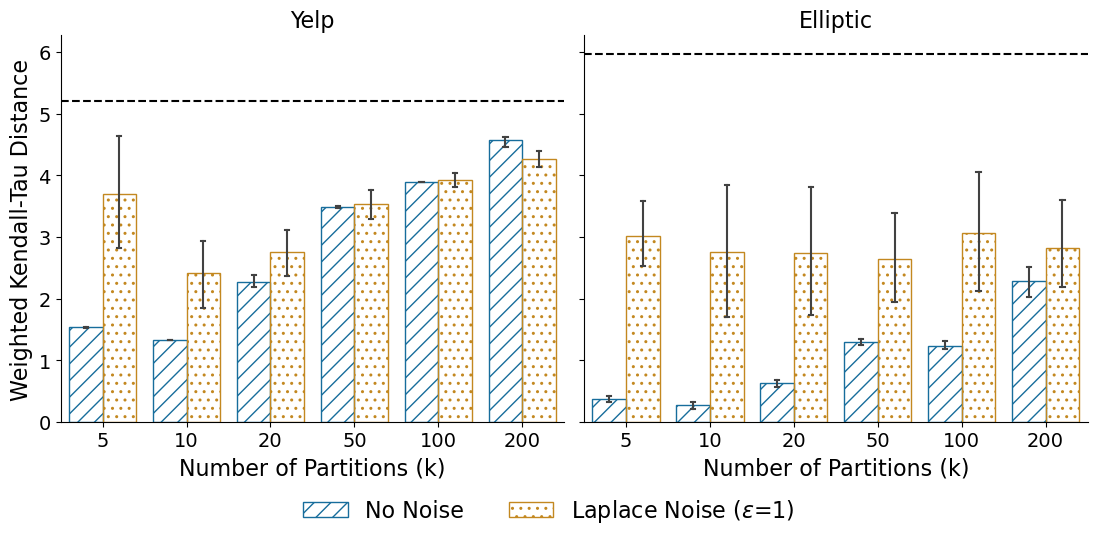

In [302]:
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, 10., random_baselines)

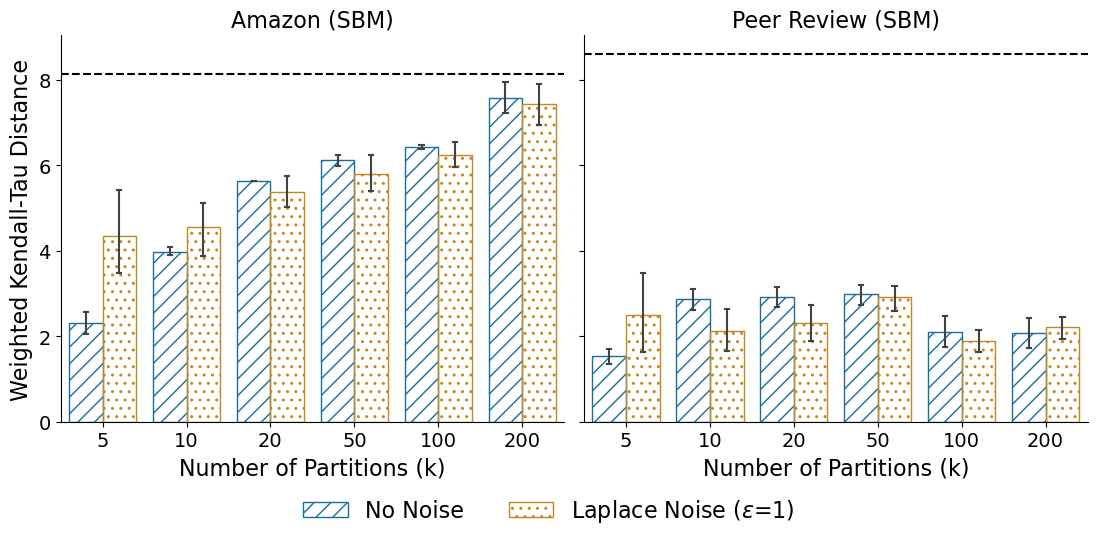

In [304]:
SUB_RATE = 0.5
DATASETS = ['amazon_sbm', 'peer_review_sbm']
plot_k_vs_kendalltau(df, SUB_RATE, DATASETS, 10., random_baselines)

## Params for Partition-Aggregate

In [418]:
df = pd.read_csv('results/pda_validation_results_leaderboard.csv')

In [419]:
# grid search over all k,sub_rate combos to see best performing in terms of kendall-tau
def get_best_params(df, datasets, eps):
    df = df[df['dataset'].isin(datasets) & (df['eps'] == eps)]
    df = df.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()
    best = [df[df['dataset'] == dataset].sort_values(by='dist', ascending=True).head(5) for dataset in datasets]
    return pd.concat(best)

def get_values(df, datasets, eps, sub_rate, k):
    df = df[(df['dataset'].isin(datasets)) & (df['eps'] == eps) & (df['sub_rate'] == sub_rate) & (df['k'] == k)]
    df = df.groupby(['dataset', 'sub_rate', 'k'])['dist'].mean().reset_index()
    return df

In [420]:
get_best_params(df, ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm'], 5.)

,dataset,sub_rate,k,dist
111,yelp,0.50,10,2.578072
100,yelp,0.10,20,2.715004
95,yelp,0.05,20,2.849192
118,yelp,0.75,20,2.871770
99,yelp,0.10,10,2.929724
59,elliptic,1.00,50,2.568136
48,elliptic,0.50,100,2.706201
39,elliptic,0.25,10,2.731826
40,elliptic,0.25,20,2.923955
60,elliptic,1.00,100,2.943110


In [294]:
get_best_params(df, ['yelp', 'elliptic', 'amazon_sbm', 'peer_review_sbm'], 10.)

,dataset,sub_rate,k,dist
105,yelp,0.25,10,1.540082
117,yelp,0.75,10,2.149784
99,yelp,0.10,10,2.345128
118,yelp,0.75,20,2.369528
111,yelp,0.50,10,2.414980
61,elliptic,1.00,200,1.643911
54,elliptic,0.75,100,1.745204
53,elliptic,0.75,50,1.843629
59,elliptic,1.00,50,2.043227
33,elliptic,0.10,10,2.240528


## Analyze Noise to Sufficient Statistics of Graph Models for Different Thresholds at varying epsilon

In [20]:
df = pd.read_csv('results/synthetic_param_estimation.csv', sep=',')
list_cols = ['sbm_params', 'sbm_params_err', 'degree_seq', 'degree_seq_err']
for c in list_cols:
    df[c] = df[c].replace(np.nan, '[]').apply(lambda x: np.array(ast.literal_eval(x)))

In [21]:
df.head()

,eps,deg_cutoff_rate,iters,non_private,iter,dataset,synthetic_algo,sbm_params,sbm_params_err,degree_seq,n_edges,n_triangles,n_edges_flipped,degree_seq_err,n_triangles_err,n_edges_err
0,1.0,1.0,10,False,0,yelp,sbm_dp,"[0.009882529969243369, 0.0041324636377779835]","[-0.0004570713395833006, 8.091149057462554e-06]",[],NaN,NaN,NaN,[],NaN,NaN
1,1.0,1.0,10,False,0,yelp,attr_graph_simp,"[0.009882529969243369, 0.0041324636377779835]","[5.572154727083098e-05, 8.41450851790564e-05]","[0, 58, 63, 22, 18, 25, 37, 48, 39, 53, 58, 56...",NaN,NaN,NaN,"[254, -58, -63, -22, -18, -25, -37, -48, -39, ...",-27006702.0,NaN
2,1.0,1.0,10,False,0,yelp,attr_graph,"[0.009882529969243369, 0.0041324636377779835]","[0.0039913357928858025, -0.005267667762454983]","[0, 58, 63, 22, 18, 25, 37, 48, 39, 53, 58, 56...",NaN,27006702.0,NaN,"[7922, -58, -63, -22, -18, -25, -37, -48, -39,...",-26859246.0,NaN
3,1.0,1.0,10,False,0,yelp,topmfilter,[],[],[],548207.0,NaN,1317412.0,[],NaN,269167.0
4,1.0,1.0,10,False,0,elliptic,sbm_dp,"[0.0002958047432429712, 0.00014964011552216918]","[-0.02209807860052193, 0.0006579051733237419]",[],NaN,NaN,NaN,[],NaN,NaN


In [22]:
def analyze_param_error(df):
    # analyze for sbm_dp
    df_sbm = df[df['synthetic_algo'] == 'sbm_dp'].copy()
    df_sbm['rel_err'] = df_sbm['sbm_params_err'].abs() / df_sbm['sbm_params']
    rel_err = df_sbm.groupby(['eps', 'dataset', 'deg_cutoff_rate'])['rel_err'].mean().reset_index()

    return rel_err

In [24]:
analyze_param_error(df[df.eps == 5.])

,eps,dataset,deg_cutoff_rate,rel_err
0,5.0,amazon_sbm,0.50,"[1.00030834767183, 0.9951978820175926]"
1,5.0,amazon_sbm,0.75,"[0.4276935599605059, 0.2502514431126385]"
2,5.0,amazon_sbm,1.00,"[0.0016615700488718673, 0.0006484556833682626]"
3,5.0,elliptic,0.50,"[111.3315345238278, 0.2537967707287093]"
4,5.0,elliptic,0.75,"[337.1143891080566, 0.8179820471319085]"
5,5.0,elliptic,1.00,"[300.4980081368306, 14.967089185019859]"
6,5.0,peer_review_sbm,0.50,"[4.750849266592544, 0.16268509173925846]"
7,5.0,peer_review_sbm,0.75,"[0.7462048715865812, 0.023678657070006777]"
8,5.0,peer_review_sbm,1.00,"[1.1794597353040928, 0.008154004913599949]"
9,5.0,yelp,0.50,"[0.5027744551469192, 0.3171285436528734]"
